# Custom Models and Training with Tensorflow

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

2024-01-07 19:23:09.585092: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 19:23:09.722478: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 19:23:09.723557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 19:23:10.875653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Using TensorFlow like Numpy

TensorFlow's API revolves around *tensors*, which flow from operation to operation, hence the name Tensor*flow*. A tensor is usually a multidimensional array (exactly like Numpy `ndarray`), but it can also hold a scalar (a simple, value such as 42).

These tensors will be important when we create custom cost functions, custom metrics, custom layers , and more. Let's see how to create and manipulate them.

### Tensor and Operations

We can create a tensor with `tf.constant()`.

In [18]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]]) # Here's a tensor representing matrix with two rows and three columns of floats
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [19]:
tf.constant(42) #scalar

<tf.Tensor: shape=(), dtype=int32, numpy=42>

Just like `ndarray`, a `tf.Tensor` has a shape and a datatype (dtype):

In [20]:
t.shape

TensorShape([2, 3])

In [21]:
t.dtype

tf.float32

Indexing works much like NumPy:

In [22]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [23]:
t[..., 1, tf.newaxis] # ... is same as :

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

In [24]:
t[:, 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

Most importantly, all sorts of tensor operations are available:

In [25]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [26]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [27]:
t @ tf.transpose(t) # @ is for multiplication, equivalent to tf.matmul()

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

Note that writing `t + 10` is equivalent to calling `tf.add(t, 10)`

### Tensor and Numpy

Tensors play nice with Numpy: we can create a tensor from Numpy array and vice versa. We can even apply TensorFlow operations to NumPy arrays and NumPy operations to tensors:

In [28]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [29]:
t.numpy() # or np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [30]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [31]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

**WARNING:**

Notice that Numpy uses a 64-bit precision by default, while TensorFlow uses 32-bit. This is because 32-bit precision is generally more than enough for neural networks, plus it runs faster and uses less RAM. So when we create a tensor from Numpy array, make sure to set `dtype=tf.float32`

### Type Conversions

Type conversions can significantly hurt performance, and they can easily gets unnoticed when they are done automatically. To avoid this, TensorFlow does not perform any type conversion automatically: it just raises an exception if we try to execute an operation on tensors with compatible types. For example: we cannot add a float tensor and an integer tensor, and we cannot even add a 32-bit float and a 64-bit float:

In [32]:
tf.constant(2.) + tf.constant(40)

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2] name: 

In [33]:
try:
    tf.constant(2.) + tf.constant(40)
except Exception as e:
    print(e)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2] name: 


In [34]:
try:
    tf.constant(2.) + tf.constant(40., dtype=tf.float64)
except Exception as e:
    print(e)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2] name: 


This may be a bit annoying at first, but remember that it's for good cause! And ofcourse we can use `tf.cast()` when we really need to convert types:

In [35]:
t2 = tf.constant(40, dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### Variables

The `tf.Tensor` values we've seen so far are immutables: we cannot modify them. This means that we cannot use regular tensors to implement weights in neural networks, since they needs to be tweaked by backpropogation. What we need is `tf.Variable`

In [36]:
v = tf.Variable([[1, 2, 3], [4, 5, 6]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)>

A `tf.Variable` acts much like a `tf.Tensor`: we can perform the same operations with it, it plays nicely with Numpy as well, and it is just as picky with types. But it can also be modified in place using `assign()` method (direct assignment will not work)

In [37]:
v.assign(2*v)
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=int32, numpy=
array([[ 2,  4,  6],
       [ 8, 10, 12]], dtype=int32)>

In [38]:
v[0,1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=int32, numpy=
array([[ 2, 42,  6],
       [ 8, 10, 12]], dtype=int32)>

In [39]:
v[:, 2].assign([0, 1])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=int32, numpy=
array([[ 2, 42,  0],
       [ 8, 10,  1]], dtype=int32)>

In [40]:
v.scatter_nd_update(indices=[[0,0], [1,2]], updates=[100, 200])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=int32, numpy=
array([[100,  42,   0],
       [  8,  10, 200]], dtype=int32)>

**NOTE:**

In practice we will rarely have to create variables manually.

### Other Data Structures

- Sparse tensors (`tf.SparseTensor`) => Tensors containing mostly zeros
- Tensor Arrays (`tf.TensorArray`) => List of tensors
- Ragged Tensors (`tf.RaggedTensor`) => static list of lists of tensors. Every tensor has same shape and data type
- String Tensors => Regular tensor of type `tf.string`
- Sets
- Queues

## Customizing Model and Training Algorithms

Let's start by creating a custom loss function, which is simple and common use case.

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [8]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### Custom Loss Function

Suppose we want to train a linear regression model, but our training set is a bit noisy. Ofcourse, we start by trying to clean up the dataset by removing or fixing the outliers, but that turns out to be insufficient; the dataset is still noisy. 

Which loss function should we use? The mean squared error might penalize large errors too much and cause model to be imprecise. The mean absolute error would not penalize outliers as much, but training might take a while to converge, and trained model not be very precise. This is probably good time to use Huber loss instead of the good old MSE. 

The Huber loss is not currently part of the official Keras API, but it is available in tf.keras (just use an instance of the `keras.losses.Huber` class). But let's pretend it's not there: implementing it is easy as pie!.

Just create a function that takes the labels and parameters as arguments, and use TensorFlow operations to compute every instance's loss:

Hubber Loss:
$$
L_{\delta}(a) =
\begin{cases}
    \frac{1}{2} a^2 & \text{for |a|} \le \delta \\
    \delta \cdot (|a| - \frac{1}{2} \cdot \delta) , & otherwise
\end{cases}
$$

In [42]:
def huber_loss_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1 # here the delta = 1
    squared_loss = tf.square(error) / 2
    linear_loss = 1 * (tf.abs(error) - (0.5 * 1))
    return tf.where(is_small_error, squared_loss, linear_loss) # returns squared loss when error is small, else returns linear loss

It is also preferable to return a tensor containing one loss per instance, rather than returning the mean loss. This way, Keras can apply class weights or sample weights when requested.

Now we can use this loss when we compile the Keras model, then train our model. When compiling the model, just pass this function to `loss` argument like this:
```
model.compile(loss=huber_loss_fn, optimizer="nadam")
```

In [43]:
input_shape = X_train.shape[1:] # (8,1)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                      input_shape=input_shape),
    keras.layers.Dense(1)
])

model.compile(loss=huber_loss_fn, optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 0.5731 - mae: 0.9348 - val_loss: 0.3381 - val_mae: 0.6284
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2123 - mae: 0.5053 - val_loss: 0.2907 - val_mae: 0.5726


And that's it! For each batch during training, Keras will call the `huber_fn()` to compute the loss and use it to perform a Gradient Descent step. Moreover, it will keep track of the total loss since the beginning of the epoch, and it will display the mean loss. 

But what happens to this custom loss when we save the model?

### Saving and Loading Models That Contain Custom Components

In [44]:
model.save("my_model_with_a_custom_loss.keras")

Saving a model containing custom loss function works fine, as Keras saves the name of the function. Whenever we load it, we we'll need to provide a dictionary that maps the function name to the actual function.

More generally, when we load a model containing custom objects, we need to map the names of the objects:

In [45]:
model = keras.models.load_model("my_model_with_a_custom_loss.keras", 
                               custom_objects={"huber_loss_fn": huber_loss_fn})

In [46]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2017 - mae: 0.4893 - val_loss: 0.2442 - val_mae: 0.5253
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1952 - mae: 0.4809 - val_loss: 0.2016 - val_mae: 0.4813


With the current implementation, any error between -1 and 1 is considered "small". But what if we want a different threshold? One solution is to create a function that creates a configured loss function:

In [47]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold 
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [48]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [49]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2145 - mae: 0.4774 - val_loss: 0.2259 - val_mae: 0.4760
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2099 - mae: 0.4727 - val_loss: 0.2013 - val_mae: 0.4587


In [50]:
model.save("my_model_with_custom_loss_threshold_2.keras")

Unfortunately, when we save the model, the `threshold` will not be saved. This means that we will have to specify the `threshold` value when loading the model (note that the name to use is "`huber_fn`", which is the name of the function we gave Keras, not the name of the function that created it):

In [51]:
model = keras.models.load_model("my_model_with_custom_loss_threshold_2.keras",
                               custom_objects={"huber_fn": create_huber(2.0)})

In [52]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.2052 - mae: 0.4665 - val_loss: 0.2369 - val_mae: 0.4675
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2043 - mae: 0.4639 - val_loss: 0.2005 - val_mae: 0.4569


We can solve this by creating a subclass of `keras.losses.Loss` class, and then implementing its `get_config()` method:

In [53]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold 
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}
        

Explanation of above code:

- The constructor accepts ``**kwargs` and passes them to the parent constructor, which handles standard hyperparameters: the `name` of the loss and the `reduction` algorithm to use to aggregate the individual instance losses. By default, it is ``"sum_over_batch_size"`, which means that the loss will be the sum of the instance losses, weighted by the sample weights, if any, and divided by the batch size (not by the sum of weights, so this is not the weighted mean). Other possible values are `"sum"` and `None`.

- The `call()` method takes the labels and predictions, computes all the instance losses, and returns them.

- The `get_config()` method returns a dictionary mapping each hyperparameter name to its value. It first calls the parent class’s `get_config()` method, then adds the new hyperparameters to this dictionary.

We can than use any instance of the class when we compile the model:

In [54]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=HuberLoss(2.0), optimizer="nadam", metrics=["mae"])

h = model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.9749 - mae: 1.0742 - val_loss: 0.4231 - val_mae: 0.6038
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2504 - mae: 0.5184 - val_loss: 0.3407 - val_mae: 0.5439


When we save the model, the threshold will get saved along with it.

In [55]:
model.save("my_model_with_custom_loss_class.kears")

INFO:tensorflow:Assets written to: my_model_with_custom_loss_class.kears/assets


INFO:tensorflow:Assets written to: my_model_with_custom_loss_class.kears/assets


And when we load the model, we just need to map the class name to class itself:

In [56]:
model = keras.models.load_model("my_model_with_custom_loss_class.keras",
                               custom_objects={"HuberLoss": HuberLoss})

When we save a model, Keras calls the loss instance's `get_config()` method and saves the config as the JSON. When we load the model, it calls the `from_config()` class method on `HuberLoss` class: this method is implemented by the base class (Loss) and creates an instance of the class, passing `**config` to the constructor. 

That's it for losses! Similar for activation functions, initializers, regularizers and constraints. Let's look at these now.

### Custom Activation Functions, Initializers, Regularizers and Constraints

Most of the Keras functionalities, such as losses, regularizers, constraints, initializers, metrics, activation functions, layers, and even full models, can be customized in very much same way. Most of the time, we just need to write a simple function with appropriate inputs and outputs.

Here are some examples:

Custom activation function `softplus`:

$$
 Y = log(1 + e^x)
$$

`softplus` is smooth continuous version of ReLU

In [34]:
def my_softplus(z):
    return tf.math.log(tf.exp(z) + 1.0) # same as tf.nn.softplus(z)

A custom Glorot Initializer:

$$
 \text{Normal distribution with mean 0 and variance } {\sigma}^2 = \frac{1}{fan_{avg}} \\
  \text{where, } fan_{avg} = \frac{fan_{in} + {fan_{out}}}{2}
$$

In [58]:
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt( 2 / (shape[0]  + shape[1]))
    #tf.random.normal outputs random values from a normal distribution
    return tf.random.normal(shape=shape, mean=0.0, stddev=stddev, dtype=dtype) # same as keras.initializers.glorot_normal()

A custom $l_1$ regularizer:
$$
    Penalty = \lambda \cdot \sum_{i=1}^N |w_i|
$$

In [59]:
def my_l1_regularizer(weights):
    # here lambda = 0.01
    """
    this tf.reduce_sum() will calculate the sum of all the values in the tensor.
    For example:
    t = [[1,1,1], [1,1,1]]
    tf.reduce_sum(t) ==> 6 
    
    So here, this tf.reduce_sum() acts as sigma (summation)
    """
    return tf.reduce_sum(tf.abs(0.01 * weights)) # eqv to keras.regularizer.l1(0.01)

A custom constraint that ensures weights are all positive:

In [67]:
def my_positive_weights(weights):
    """
    tf.zeros_like creates a tensor with all elements set to zero
    """
    # return value is same as tf.nn.relu()
    return tf.where(weights < 0., tf.zeros_like(weights), weights) # eqv to keras.constraints.nonneg() or tf.nn.relu()

These custom function then can be used normally.

In [68]:
layer = keras.layers.Dense(1, activation=my_softplus, kernel_initializer=my_glorot_initializer,
                          kernel_regularizer=my_l1_regularizer, 
                          kernel_constraint=my_positive_weights)

The activation function will be applied to the output of this `Dense` layer, and its result will be passed on to the next layer. The layer's weights will be initialized using the value returned by the initializer. At each training step the weights will be passed to the regularization function to compute the regularization loss, which will be added to the main loss to get the final loss used for training. Finally, the constraint function will be called after each training step, and the layer's weights will be replaced by the constrained weights.

In [70]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                      input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus, kernel_initializer=my_glorot_initializer,
                          kernel_regularizer=my_l1_regularizer, 
                          kernel_constraint=my_positive_weights)
])

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

h = model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.7512 - mae: 0.9273 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.6521 - mae: 0.5370 - val_loss: inf - val_mae: inf


In [71]:
model.save("my_model_with_many_custom_parts.keras")

In [72]:
model = keras.models.load_model("my_model_with_many_custom_parts.keras",
                               custom_objects={
                                   "my_l1_regularizer": my_l1_regularizer,
                                   "my_positive_weights": my_positive_weights,
                                   "my_glorot_initializer": my_glorot_initializer,
                                   "my_softplus": my_softplus
                               })

If the function has hyperparameters that need to be saved along with a model, then we will want to subclass the appropriate class, such as `keras.regularizers.Regulizer`, `keras.constraints.Constraint`, `keras.initializers.Initializer` or `keras.layers.Layer` (for any layer including activation functions). Much like we did for custom loss, here's a simple class for $l_1$ regularization that saves its `factor` hyperparameter (this time we do not need to call the parent constructor or the `get_config()` method, as they are not defined by the parent class):

In [73]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(self.factor * tf.abs(weights))
    def get_config(self):
        return {"factor": self.factor}

Note that we must implement the `call()` method for losses, layers (including activation functions), and models, or the `__call__()` method for regularizers, initializers, and constraints. For metrics, things are bit different, we will see them in a while.

In [74]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                      input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus, 
                       kernel_initializer=my_glorot_initializer,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights)
])

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

h = model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.7632 - mae: 0.9487 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.6212 - mae: 0.5393 - val_loss: inf - val_mae: inf


In [78]:
model.save("my_model_with_many_custom_parts.keras")

In [79]:
model = keras.models.load_model("my_model_with_many_custom_parts.keras",
                               custom_objects={
                                   "MyL1Regularizer": MyL1Regularizer,
                                   "my_positive_weights": my_positive_weights,
                                   "my_glorot_initializer": my_glorot_initializer,
                                   "my_softplus": my_softplus
                               })

### Custom Metrics

In [84]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                      input_shape=input_shape),
    keras.layers.Dense(1)
])

In most cases, defining a custom metric function is exactly the same as defining a custom loss function. In fact, we could even use the Huber loss function we created earlier as a metric; (however, Huber loss is seldom used as metric, MSE or MAE is preferred) it would just work fine:

In [85]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [86]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 876us/step - loss: 2.8613 - huber_fn: 1.0737
Epoch 2/2
363/363 [==============================] - 0s 924us/step - loss: 0.8171 - huber_fn: 0.2885


For each batch during training, Keras will compute this metric and keep track of its mean since the beginning of the epoch. Most of the time, this is exactly what we want. But not always!

Consider a binary classifier's precision, for example. As we saw in Chapter 3, precision is the number of true positives, divided by the number of positive predictions (including both true and false positives). Suppose the model made five positive predictions in first batch, four of which were correct: that's 80% prediction. 

Then suppose model made three positive predictions in the second batch, but they all were incorrect: that's 0% precision for the second batch. If we compute the mean of these two precisions, we get 40%. 

But wait a second - that's *not* the model's precision over these two batches! Indeed, there were total of 4 true positives (4 + 0) out of 8 positive predictions (5 + 3), so the overall precision is 50% and not 40%. 

What we need is an object that can keep track of the number of true positives and the number of false positives and that can compute their ratios when requested. 

This is precisely what the `keras.metrics.Precision` class does:

In [88]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1]) # labels and predictions for 1st batch

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [89]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0]) # labels and predictions for 2nd batch

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In this example, we create a `Precision` object, then we used it like a function, passing it a label and predictions for the first batch, then for the second batch (we could also have passed sample weights). We used the same number of true and false positives as in the example we just discussed. 

After the first batch, it returns a precision of 80%; then after the second batch, it returns 50% (which is overall precision so far, not the second batch's precision). 

This is called `streaming metric` or (`stateful metric`), as it is gradually updated, batch after batch.

At any point, we can call the `result()` method to get the current value of the metric.

In [91]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

We can also look at its variables (tracking the number of true and false positives) by using the `variables` attribute.

In [92]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

We can reset these variables using the `rest_states()` method:

In [94]:
precision.reset_states() # both variables will get reset to 0.0

In [96]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

If we need to create such a streaming metric, create a subclass of `keras.metrics.Metric` class. 

Here's the simple example that keeps track of the total Huber loss and the number of instances seen so far. When asked for result, it returns the ratio, which is simply the mean Huber loss:

In [114]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        # add_weight adds a new variable to the layer
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        This method is called when we use an instance of this class as function (as we did with
        `Precision` object). It updates the variables, given the labels and predictions for one batch
        (and sample weights, but in this case we ignore them). 
        """
        metric = self.huber_fn(y_true, y_pred)
        # assign_add() is to update the variable. Since in tf, direct updation is not allowed
        self.total.assign_add(tf.reduce_sum(metric))
        # tf.size() => Returns a 0-D Tensor representing the number of elements
        self.count.assign_add(tf.cast((tf.size(y_true)), tf.float32))
    def result(self):
        """
        Computes and returns the final result, in this case the mean Huber metric over all instances.
        When we use the metric as a function, the `update_state()` method gets called first, then the
        `result()` method is called, and its output is returned
        """
        return self.total / self.count
    def get_config(self):
        """
        Implemented this method to ensure that `threshold` gets saved along with the model. 
        """
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [102]:
m = HuberMetric(2.0)

"""
error (10 - 2 = 8) > threshold (2) . Therefore it will act linearly
 total = 2 * (|10-2| - 2/2) = 14
 count = 1
 result = 14 / 1 = 14
"""

# y_true, y_pred
m(tf.constant([[2.]]), tf.constant([[10.]]))

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [103]:
# total = total + (|1-0|^2 / 2) + (2 * (|9.25 - 5| - 2/2)) = 14 + 0.5 + 6.5 = 21
# count = count + 2 = 1 + 2 = 3
# result = total / count = 21 / 3 = 7

m(tf.constant([[0.], [5.]]) , tf.constant([[1.], [9.25]]))

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [105]:
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [106]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [107]:
m.reset_states()

In [108]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

Let's check that the `HuberMetric` class works well:

In [115]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal", 
                      input_shape=input_shape),
    keras.layers.Dense(1)
])

model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

h = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.9816 - huber_metric: 0.9816
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2520 - huber_metric: 0.2520


In [116]:
model.save("my_model_with_a_custom_metric.keras")

In [117]:
model = keras.models.load_model("my_model_with_a_custom_metric.keras",
                               custom_objects={
                                   "huber_fn": create_huber(2.0),
                                   "HuberMetric": HuberMetric
                               })

In [118]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2299 - huber_metric: 0.2299
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2219 - huber_metric: 0.2219


In [120]:
model.metrics

In [121]:
model.metrics[-1].threshold

2.0

When we define a metric using a simple function, Keras automatically calls it for each batch, and it keeps track of the mean durin each epoch, just like we did manually. So the only benefit of our `HuberMetric` class is that the `threshold` will be saved. But of course, some metrics like precision, cannot simply be averaged over batches, in those cases, there's no other option than to implement a streaming metric. 

More simply, we could have the created the class like this:

In [127]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name="HuberMetric", dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

This class handles shapes better, and it also supports sample weights.

In [128]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                      input_shape=input_shape),
    keras.layers.Dense(1)
])

model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

sample_weight = np.random.rand(len(y_train))
h = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
             epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.3758 - HuberMetric: 0.7602
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.1223 - HuberMetric: 0.2494


In [129]:
h.history["loss"][0] , h.history["HuberMetric"][0] * sample_weight.mean()

(0.37584829330444336, 0.37724936285833965)

In [130]:
model.save("my_model_with_a_custom_metric_v2.keras")

In [131]:
model = keras.models.load_model("my_model_with_a_custom_metric_v2.keras",
                               custom_objects={
                                   "HuberMetric": HuberMetric
                               })

In [132]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2344 - HuberMetric: 0.2344
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2235 - HuberMetric: 0.2235


In [137]:
model.metrics[-1].threshold

2.0

Now we have built a streaming metric, building a custom layer will seem like a walk in park. 

### Custom Layers

Let's see how to build custom layers. 

First, some layers have no weights, such as `keras.layers.Flatten` or `keras.layers.ReLU`. If we want to create a custom layer without any weights, the simplest option is to write a function and wrap it in a `keras.layers.Lambda` layer. For eg: the following layer will apply the exponential function to its input:

In [138]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [140]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

This custom layer can then be used like any other layer, using the Sequential API, the Functional API or the Subclassing API. We can also use it as activation function (or we could use `activation=tf.exp, activation=keras.activations.exponential`, or simply `activation="exponential"`).
Adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with a very different scales (e.g 0.001, 10, 10000).

In [142]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])

model.compile(loss="mse", optimizer="SGD")

h = model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 0.6991 - val_loss: 0.4308
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4440 - val_loss: 0.3812
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5031 - val_loss: 0.3808
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4053 - val_loss: 0.3649
Epoch 5/5
162/162 [==============================] - 0s 745us/step - loss: 0.3731


0.37313514947891235

To build a custom stateful layer (i.e., layer with weights), we need to create a subclass of the `keras.layers.Layer` class. 

For example, the following class implements a simplified version of the `Dense` Layer:

In [145]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        
        """
        Convers the activation argument to appropriate activation function using
        `keras.activations.get()` function (it accepts function strings like "relu" or "selu" or
        simple None). [This function is specifig to tf.keras . We could also use
        keras.activations.Activation()]
        """
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        """
        Role is to create layer's variables by calling `add_weight()` method for each weight. 
        """
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at end
        
    def call(self, X):
        """
        This method performs the desired operations. In this case, we compute the matrix
        multiplication of the inputs X and the layer's kernel, we add the bias vector, and we 
        apply the activation function to the result, and this gives the output of the layer
        """
        return self.activation(X @ self.kernel + self.bias)
    
    def compute_output_shape(self, batch_input_shape):
        """
        Simply returns the shape of this layer's outputs. In this case, it is same shape as the
        inputs, except the last dimension is replaced with the number of neurons in the layer. Note
        that in tf.keras, shapes are instances of the `tf.TensorShape` class, which we can convert
        to Python lists using `as_list()`
        """
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        """
        Just like previous custom classes. We save the activation function's full configuration
        by calling `keras.activations.serialize()`.
        """
        base_config = super().get_config()
        return {**base_config, 
                "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

Code explanation:

- The constructor takes all the hyperparameters as arguments (in this example, units and activation), and importantly it also takes `**kwargs` argument. It calls the parent constructor, passing it `kwargs`: this takes care of standard arguments such as `input_shape`, `trainable` and `name`. Then it saves the hyperparameters as attributes. 

- The `build()` method is called the first time layer is used. At that point, Keras will know the shape of this layer's inputs, and it will pass it to the `build()` method, which is often necessary to create some of the weights. For ex: we need to know the number of neurons in the previous layer in order to create the connection weights matrix (i.e the "kernal"): this corresponds to the size of the last dimension of the inputs. At the end of the `build()` method (and only at the end), we must call the parent's `build()` method: this tells Keras that the layer is built (it just sets `self.built=True`)

We can now use a `MyDense` layer just like any other layer:

**NOTE:**

We can generally omit the `compute_output_shape()` method, as tf.keras automatically infers the output shape, except where the layer is dynamic (we will see shortly).

In [146]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

model.compile(loss="mse", optimizer="nadam")

h = model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.3340 - val_loss: 0.6066
Epoch 2/2
162/162 [==============================] - 0s 851us/step - loss: 0.4712


0.47121259570121765

In [147]:
model.save("my_model_with_a_custom_layer.keras")

In [148]:
model = keras.models.load_model("my_model_with_a_custom_layer.keras",
                               custom_objects={
                                   "MyDense": MyDense
                               })

To create a layer with multiple inputs (e.g: `Concatenate`), the argument to `call()` method should be tuple containing all the inputs, and similarly the argument to the `compute_output_shape()` method should be a tuple containing each input's batch shape. 

To create a layer with multiple outputs, the `call()` method should return a list of outputs, and `compute_output_shape()` should return the list of batch output shapes (one per output). 

For ex: the following toy layer takes two inputs and returns three outputs:

In [152]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape, " X2.shape: ", X2.shape) 
        return X1 + X2, X1 * X2
    
    def compute_output_shape(self, batch_input_shape):
        b1, b2 = batch_input_shape
        return [b1, b1, b1]

This layer may now be used like any other layer, but of course only using the Functional or Subclassing APIs, not the Sequential API (which accepts layers with one input and one output). 

Our custom layer can be called using the functional API like this:

In [153]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


Note that the `call()` method receives symbolic inputs, whose shape is only partially specified (at this stage, we don't know the batch size, which is why the first dimension is `None`):

We can also pass the actual data to the custom layer. To test this, let's split each dataset's input into two parts, with four features each:

In [155]:
def split_data(data):
    columns_count = data.shape[-1]
    half = columns_count // 2
    return data[:, :half], data[:, half:]

X_train_scaled_A, X_train_scaled_B = split_data(X_train_scaled)
X_valid_scaled_A, X_valid_scaled_B = split_data(X_valid_scaled)
X_test_scaled_A, X_test_scaled_B = split_data(X_test_scaled)

X_train_scaled_A.shape, X_train_scaled_B.shape

((11610, 4), (11610, 4))

In [156]:
outputs1, outputs2 = MyMultiLayer()((X_train_scaled_A, X_train_scaled_B))

X1.shape:  (11610, 4)  X2.shape:  (11610, 4)


Now notice above, shapes are fully specified.

Let's build a more complete model using the functional API (this is just a toy model):

In [157]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

input_A = keras.layers.Input(shape=X_train_scaled_A.shape[-1])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[-1])
hidden_A, hidden_B = MyMultiLayer()((input_A, input_B))
hidden_A = keras.layers.Dense(30, activation="selu")(hidden_A)
hidden_B = keras.layers.Dense(30, activation="selu")(hidden_B)
concat = keras.layers.Concatenate()((hidden_A, hidden_B))
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

X1.shape:  (None, 4)  X2.shape:  (None, 4)


In [159]:
model.compile(loss="mse", optimizer="nadam")

In [160]:
h = model.fit((X_train_scaled_A, X_train_scaled_B), y_train, epochs=2, 
             validation_data=((X_valid_scaled_A, X_valid_scaled_B), y_valid))

Epoch 1/2
X1.shape:  (None, 4)  X2.shape:  (None, 4)
X1.shape:  (None, 4)  X2.shape:  (None, 4)
363/363 [==============================] - 1s 2ms/step - loss: 1.9091 - val_loss: 1.4686
Epoch 2/2
363/363 [==============================] - 1s 1ms/step - loss: 0.9841 - val_loss: 1.1028


If our layer needs to have a different behaviour during training and during testing (e.g., if it uses `Dropout` or `BatchNormalization` layers), then we must add a `training` argument to `call()` method and to use this argument to decide what to do.

For ex., let's create a layer that adds Gaussian noise during training (for regularization) but does nothing during testing (Keras has a layer that does the same thing, `keras.layers.GaussianNoise`):

In [162]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev
    
    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X
    
    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

Here's a simple model that uses this custom layer:

In [165]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="nadam")
h = model.fit(X_train_scaled, y_train, epochs=2, 
             validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 2.2817 - val_loss: 1.2067
Epoch 2/2
162/162 [==============================] - 0s 709us/step - loss: 0.7399


0.7398827075958252

Now let's create custom models:

### Custom Models

In [167]:
X_new_scaled = X_test_scaled

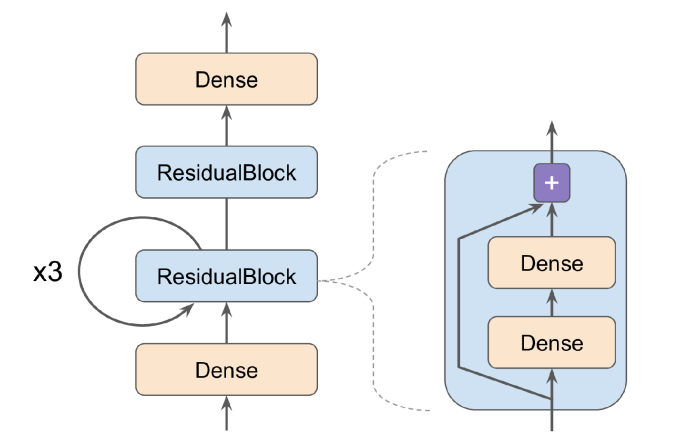

Note that this model does not make much sense; it's just an example to illustrate the fact that we can easily build any kind of model we want, even one that contains loop and skip connections.

To implement this model, it is best to first create a `ResidualBlock` layer, since we are going to create a couple of identical blocks (and we might want to use it in another model):

In [166]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu", 
                                          kernel_initializer="he_normal")
                      for _ in range(n_layers)]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
            return inputs + Z

This layer is bit special since it contains other layers. This is handeled transparent by Keras: it automatically detects the `hidden` attribute contains trackable objects (layers in this case), so their variables are automatically added to this layer's list of variables. 

Next, let's use the Subclassing API to define the model itself:

In [168]:
class ResidualRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                         kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)
        
    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range (1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

We create the layers in the constructor and use them in the `call()` method. This model then can be used like any other model.

In [169]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
h = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 2s 1ms/step - loss: 57.0355
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 8.3522
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 1.6286
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 1.0257
Epoch 5/5
162/162 [==============================] - 0s 691us/step


If we also want to be able to save the model using the `save()` method and load it using the `keras.models.load_model()` function, we must implement the `get_config()` method (as we did earlier), in both the `ResidualBlock` and `ResidualRegressor` class. Alternatively we can save and load the weights using `save_weights()` and `load_weights()` methods. 

We could have defined the same model using the Sequential API instead like this:

In [171]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

block1 = ResidualBlock(2, 30)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", 
                      kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="nadam")
h = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 1.7440
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.7228
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5986
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4572
Epoch 5/5
162/162 [==============================] - 0s 737us/step


With that, we can naturally and concisely build almost any model that
we find in a paper, using the Sequential API, the Functional API, the
Subclassing API, or even a mix of these. “Almost” any model? Yes, there
are still a few things that we need to look at: first, how to define losses or
metrics based on model internals, and second, how to build a custom
training loop.

### Losses and Metrics Based on Model Internals

To define a custom loss based on models internals, compute it based on any part of the model we want, then pass the result to the `add_loss()` method. 

For example: Let's build a custom regression MLP model composed of a stack of five hidden layers plus an output layer. This custom model will also have an auxiliary output on the top of the upper hidden layer. The loss associated to this auxiliary output will be called the *reconstruction* loss (more in Ch-17): it is the mean squared difference between the reconstruction and the inputs. 

By adding this reconstruction loss to the main loss, we will encourage the model to preserve as much information as possible through the hidden layers - even information that is not directly useful for the regression task itself. In practice, this loss sometimes improves generalization (it is a regularization loss).

Here is the code for this custom model with custom reconstruction loss:

In [11]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        """
        Constructor creates the DNN with 5 dense hidden layers and one dense output layer
        """
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal")
                      for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        
    def build(self, batch_input_shape):
        """
        This method creates an extra dense layer which will be used to reconstruct the inputs to the
        model. 
        """
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        # super().build(batch_input_shape) #Due to an issue introduced in TF 2.2 (#46858), we must not call super().build() inside the build() method.
    
    def call(self, inputs):
        """
        This method processes the inputs through all five hidden layers, then passes the result to
        the reconstruction layer, which produces the reconstruction. 
        """
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        """
        Then call method computes the reconstruction loss and adds it to the model's list of losses
        using `add_loss()` method (We can also add add_loss on any layer inside the model, as the
        model recursively gathers losses from all its layers. )
        """
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        """
        We scaled down the reconstruction loss by multiplying it by 0.05 (this is hyperparameter we
        can tune). This ensures that the reconstruction loss does not dominate the main loss. 
        """
        self.add_loss(0.05 * recon_loss)
        return self.out(Z)

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
h = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 [==============================] - 3s 2ms/step - loss: 0.6997
Epoch 2/2
162/162 [==============================] - 0s 891us/step


Similarly, we can add a custom metric model on the models internals by computing it in any way we want, as long as the result is the output of a metric object. For example: we can create a `keras.metric.Mean` object in the constructor, then call it in the `call()` method, passing it the `recon_loss`, and finally add it to the model by calling the model's `add_metric()` method. This way, when we train the model, Keras will display both the mean loss over each epoch and the mean reconstruction error over each epoch. Both will go down during training.

In [12]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        """
        Constructor creates the DNN with 5 dense hidden layers and one dense output layer
        """
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal")
                      for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")
        
    def build(self, batch_input_shape):
        """
        This method creates an extra dense layer which will be used to reconstruct the inputs to the
        model. 
        """
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        # super().build(batch_input_shape) #Due to an issue introduced in TF 2.2 (#46858), we must not call super().build() inside the build() method.
    
    def call(self, inputs, training=None):
        """
        This method processes the inputs through all five hidden layers, then passes the result to
        the reconstruction layer, which produces the reconstruction. 
        """
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        """
        Then call method computes the reconstruction loss and adds it to the model's list of losses
        using `add_loss()` method (We can also add add_loss on any layer inside the model, as the
        model recursively gathers losses from all its layers. )
        """
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        """
        We scaled down the reconstruction loss by multiplying it by 0.05 (this is hyperparameter we
        can tune). This ensures that the reconstruction loss does not dominate the main loss. 
        """
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
h = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 [==============================] - 2s 1ms/step - loss: 0.8096 - reconstruction_error: 0.7123
Epoch 2/2
162/162 [==============================] - 0s 760us/step


### Computing Gradients Using Autodiff

To compute gradients automatically, let's consider a simple toy function:

In [14]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

The partial derivative of this function wrt to `w1` is `6*w1 + 2*w2` and wrt to `w2` is `2 * w1`. For example, at point `(w1, w2)` = `(5, 3)`, these partial derivatives are equal to `36` and `10` respectively, so the gradient vector at this point is `(36, 10)`. But if this were a neural network, the function would be much more complex, typically with tens of thousands of parameters, and finding the partial derivatives analytically by hand would be an almost impossible task, 

One solution could be to compute and approximation of each partial derivative by measuring how much the function's output changes when we tweak the corresponding parameter:

In [16]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1+eps, w2) - f(w1,w2)) / eps

36.000003007075065

In [17]:
(f(w1, w2+eps) - f(w1, w2)) / eps

10.000000003174137

Looks about right! This works rather well and is easy to implement, but it is just an approximation, and importantly we need to call `f()` at least once per parameter (not twice, as we could compute `f(w1,w2)` just once). Needing to call `f()` at least once per parameter makes this approach intractable for large neural networks.

So instead, we should use autodiff. TensorFlow makes this pretty simple:

In [19]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)
    
gradients = tape.gradient(z, [w1, w2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

We first define two variables `w1` and `w2`, then we create a `tf.GradientTape` context that will automatically record every operation that involves a variable, and finally we ask this tape to compute the gradient of the result `z` wrt to both variables `[w1, w2]`.

The tape is automatically erased immediately after we call its `gradient()` method, so we will get an exception if we try to call `gradient()` twice.

In [20]:
with tf.GradientTape() as tape:
    z = f(w1, w2)
    
dz_dw1 = tape.gradient(z, [w1])
dz_dw2 = tape.gradient(z, [w2])

RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)

If we need to call `gradient()` more than once, we must make the tape persistant and delete it each time we are done with it to free resources. 

In [21]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, [w1])
dz_dw2 = tape.gradient(z, [w2])
del tape

In [22]:
dz_dw1, dz_dw2

([<tf.Tensor: shape=(), dtype=float32, numpy=36.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=10.0>])

By default, the tape will only track operations involving variables, so if we try to compute the gradient of `z` wrt anything other than variable, the result will be `None`:

In [29]:
c1, c2 = tf.Variable(5.) , tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [w1, w2])

In [27]:
gradients

[None, None]

However, we can force the tape to watch any tensors we like, to record every operation that involves them. We can then compute gradients wrt these tensors, as if they were variables:

In [31]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [32]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In some cases, we may need to stop gradients from backpropogating through some part of our neural network. To do this, we must use the `tf.stop_gradient()` function. The function returns its inputs during the forward pass (like `tf.identity()`), but it does not let gradients through backpropogation (it acts like a constant):

In [33]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)
    
gradients = tape.gradient(z, [w1, w2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

Finally, we may occasionally run into some numerical issues when computing gradients. For example, if we compute the gradients of the `my_softplus()` function for large inputs, the result will be `NaN`:

In [35]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

This is because computing the gradient of this function using autodiff leads to some numerical difficulties: due to floating-point precision errors, autodiff ends up computing infinity divided by infinity (which return NaN). 

Analytically, the derivative of the softplus function is just
$$
\frac{e^x}{1+e^x} = \frac{1}{1 + \frac{1}{e^x}}
$$
, which is numerically stable. Next, we can tell TensorFlow to use this stable function when computing the gradients of the `my_softplus()` function by decorating it with `@tf.custom_gradient` and making it return both its normal output and the function that computes the derivatives (note that it will receive as inputs the gradients that were backpropogated so far, down to the softplus function; and according to the chain rule, we should multiply them with this function's gradients):

In [36]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1/exp)
    return tf.math.log(exp + 1), my_softplus_gradients

Now when we compute the gradients of the `my_better_softplus()`
function, we get the proper result, even for large input values (however,
the main output still explodes because of the exponential; one workaround
is to use `tf.where()` to return the inputs when they are large).

In [37]:
def my_better_softplus(z):
    return tf.where(z>30, z, tf.math.log(tf.exp(z) + 1))

In [38]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)
    
z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

### Custom Training Loops

In some rare case, the `fit()` method may not be flexible enough for what we need to do. For example, the Wide and Deep paper , uses two different optimizers: one for wide path and the other for deep path. Since the `fit()` method only uses one optimizer (the one that we specify when compiling the model), implementing this paper requires writing our custom loop. 

First, let's build a simple model. No need to compile it, since we will handle the training loop manually:

In [40]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                      kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

Next let's create a tiny function that will randomly sample a batch of instances from the training set:

In [7]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

Let's also define a function that will display the training status, including the number of steps, the total number of steps, the mean loss since the start of epoch (i.e., we will use `Mean` metric to compute it), and other metrics:

In [56]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result()) 
                          for m in [loss] + (metrics or None)])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics, end=end)

In [47]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")

for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i**2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


With that, let's get down to business! First, we need to define some hyperparameters and choose the optimizer, the loss function, and the metrics:

In [57]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

Now we are ready to build the custom loop!

In [58]:
"""
We created two nested loops: one for epochs, the other for the batches within the epochs.
Then we sample a random batch from the training set.
"""

for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        """
        Inside tf.GradientTape() we make a prediction for one batch (using model as a function),
        and we compute the loss: it is equal to main loss plus other losses
        """
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            """
            Since the `mean_squared_error()` function returns one loss per instance, we compute
            the mean over the batch using tf.reduce_mean() (if we wanted to apply different weights
            to each instance, this is where we would do it). 
            """
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            """
            add_n => returns element wise sum of list of tensors
            For ex:
            >>> a = tf.constant([[3, 5], [4, 8]])
            >>> b = tf.constant([[1, 6], [2, 9]])
            >>> tf.math.add_n([a, b, a]).numpy()
            output: [[7, 16],
                     [10,25]]
            """
            loss = tf.add_n([main_loss] + model.losses)
            
        """
        Next we ask the tape to compute the gradient of the loss wrt to each trainable variable
        (not all variables!), and we apply them to optimizer to perform a GD step.
        """
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        """
        Then we update the mean loss and the metrics (over the current epoch) and we display the
        status bar. 
        """
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    
    """
    At the end of each epoch, we display the status bar again to make it look complete and to
    print a line feed, and we reset the stats of the mean loss and metrics
    """
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 - mean: 0.6380 - mean_absolute_error: 0.5147
Epoch 2/5
11610/11610 - mean: 0.6239 - mean_absolute_error: 0.5083
Epoch 3/5
11610/11610 - mean: 0.6331 - mean_absolute_error: 0.5147
Epoch 4/5
11610/11610 - mean: 0.6270 - mean_absolute_error: 0.5126
Epoch 5/5
11610/11610 - mean: 0.6552 - mean_absolute_error: 0.5212


If we want to apply any other transformation to the gradients, simply do so before calling the `apply_gradients()` method.

If we add weight constraints to our model (e.g., by setting `kernel_constraint` or `bias_constraint` when creating a layer), we should update the training loop to apply these constraints just after `apply_gradients()`:

In [59]:
for variable in model.variables:
    if variable.constraint is not None:
        variable.assign(variable.constraint(variable))

## TensorFlow Functions and Graphs

Let's start with a trivial function that computes the cube of its input:

In [60]:
def cube(x):
    return x**3

In [61]:
cube(2)

8

In [62]:
cube(tf.constant(2))

<tf.Tensor: shape=(), dtype=int32, numpy=8>

Now let's use `tf.function()` to convert this Python function to a `TensorFlow Function`:

In [63]:
tf_cube = tf.function(cube)
tf_cube

This TF Function can then be used exactly like the original Python function, and it will return the same results (but as tensors):

In [64]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [65]:
tf_cube(tf.constant(3.0))

<tf.Tensor: shape=(), dtype=float32, numpy=27.0>

Under the hood, `tf.function()` analyzed the computations performed by the `cube()` function and generated an equivalent computation graph!

Alternatively, we could have used `tf.function` as a decorator; this is actually more common:

In [66]:
@tf.function
def tf_cube(x):
    return x**3

The original Python function is still available via the TF Function's `python_function` attribute, in case we ever need it:

In [67]:
tf_cube.python_function(2)

8

**TIP:**

We can tell Keras *not* to convert our Python Functions to TF Functions by setting `dynamic=True` when creating a custom layer or a custom model. Alternatively, we can set `run_eagerly=True` when calling the model's `compile()` method.

By default, a TF Function generates a new graph for every unique set of input shapes and data types and caches it for subsequent calls. 

For ex., if we call `tf_cube(tf.constant(10))`, a graph will be generated for int32 tensors of shape []. Then if we call `tf_cube(tf.constant(20))`, the same graph will be reused. But if we call `tf_cube(tf.constant([10,20]))`, a new graph will be generated for int32 tensors of shape [2]. This is how TF Functions handle polymorphism (i.e., varying arguments types and shapes). However, this is only true for tensor arguments: if we pass numerical Python values to a TF Function, a new graph will be generated for every distinct value: for eg., calling `tf_cube(10)` and `tf_cube(20)` will generate two graphs.

**Warning:**

If we call a TF Function many times with different numerical Python values, then many graphs will be generated, slowing down our program and using up a lot of `RAM` (we must delete the TF Function to release it). Python values should be reserved for arguments that will have few unique values, such as hyperparameters like the number of neurons per layer. This allows TF to better optimize each variant of our model.

**TIP:**

To view the generated function's source code, we will call `tf.autograph.to_code(sum_squares.python_function)`. The code is not meant to be pretty, but it can sometimes help for debugging.

## Exercises

#### 12.

Implement a custom layer that performs *Layer Normalization*

##### a. 

The `build()` method should define two trainable weights $\alpha$ and $\beta$, both of shape `input_shape[-1:]` and data type `tf.f`

##### b. 

The `call()` method should compute the mean $\mu$ and
standard deviation $\sigma$ of each instance’s features. For this,
you can use `tf.nn.moments(inputs, axes=-1,
keepdims=True)`, which returns the mean $\mu$ and the
variance $\sigma^2$ of all instances (compute the square root of
the variance to get the standard deviation). Then the
function should compute and return $\alpha \cdot \frac{(X - \mu)}{(\sigma + \epsilon)} + \beta$, where $\cdot$ represents itemwise multiplication (*) and $\epsilon$
is a smoothing term (small constant to avoid division by
zero, e.g., 0.001).

In [7]:
class LayerNormalization(keras.layers.Layer):
    def __init__(self, eps=0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
    
    def build(self, batch_input_shape):
        self.alpha = self.add_weight(name="alpha", shape=batch_input_shape[-1:], initializer="ones")
        self.beta = self.add_weight(name="alpha", shape=batch_input_shape[-1:], initializer="zeros")
        super().build(batch_input_shape) # must be at end
    
    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha * (X - mean) / (tf.sqrt(variance + self.eps)) + self.beta
    
    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "eps": self.eps}

**NOTE:**

That making $\epsilon$ was not compulsory. Also it is preferable to compute `tf.sqrt(variance + self.eps)` rather than `tf.sqrt(variance) + self.eps` because square root of x is undefined at x=0, so training will bomb whenever the variance vector has atleast one component equal to 0. Adding $\epsilon$ within the square root guarantees that this will never happen.

##### c. 
Ensure that your custom layer produces the same (or very
nearly the same) output as the
`keras.layers.LayerNormalization` layer.

In [9]:
X = X_train.astype(np.float32)

custom_layer_norm = LayerNormalization()
keras_layer_norm = keras.layers.LayerNormalization()

tf.reduce_mean(keras.losses.mean_absolute_error(keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=3.9782837e-08>

Yep, that's close enough. To be extra sure, let's make alpha and beta completely random and compare again:

In [14]:
random_alpha = np.random.rand(X.shape[-1])
random_beta = np.random.rand(X.shape[-1])

custom_layer_norm.set_weights([random_alpha, random_beta])
keras_layer_norm.set_weights([random_alpha, random_beta])

tf.reduce_mean(keras.losses.mean_absolute_error(keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=3.046251e-08>

Still negligible difference. Our custom layer works fine!

#### 13.

Train a model using a custom training loop to tackle the Fashion
MNIST dataset

##### a.

Display the epoch, iteration, mean training loss, and
mean accuracy over each epoch (updated at each
iteration), as well as the validation loss and accuracy at
the end of each epoch.

In [14]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_valid, X_train = X_train_full[:5000], X_train_full[5000: ]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255

In [3]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [5]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [23]:
from tqdm import trange
from collections import OrderedDict

with trange(1, n_epochs + 1, desc="All epochs", position=0, leave=True) as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs), position=0, 
                    leave=True) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

Epoch 1/5: 100%|█| 1718/1718 [00:55<00:00, 30.84it/s, loss=0.469, sparse_categor
2024-01-07 21:27:22.944152: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15680000 exceeds 10% of free system memory.
Epoch 2/5: 100%|█| 1718/1718 [00:57<00:00, 29.82it/s, loss=0.398, sparse_categor
2024-01-07 21:28:20.582380: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15680000 exceeds 10% of free system memory.
Epoch 3/5: 100%|█| 1718/1718 [00:57<00:00, 30.14it/s, loss=0.374, sparse_categor
2024-01-07 21:29:17.612594: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15680000 exceeds 10% of free system memory.
Epoch 4/5: 100%|█| 1718/1718 [00:57<00:00, 30.05it/s, loss=0.375, sparse_categor
2024-01-07 21:30:14.812017: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15680000 exceeds 10% of free system memory.
Epoch 5/5: 100%|█| 1718/1718 [00:57<00:00, 29.78it/s, loss=0.36, sparse_categori
2024-01-07 21:31:12.515550: W tensorflo

In [24]:
status

OrderedDict([('loss', 0.35977197),
             ('sparse_categorical_accuracy', 0.86867),
             ('val_loss', 0.41471246),
             ('val_accuracy', 0.8698)])

##### b. 

Try using a different optimizer with a different learning
rate for the upper layers and the lower layers.

In [31]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

lower_layers = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu")
])

upper_layers = keras.models.Sequential([
    keras.layers.Dense(10, activation="softmax")
])

model = keras.models.Sequential([
    lower_layers, upper_layers
])

In [32]:
lower_optimizer = keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = keras.optimizers.Nadam(learning_rate=1e-3)

In [33]:
n_epochs = 5
batch_size = 16
n_steps = len(X_train) // batch_size
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [35]:
from tqdm import trange
from collections import OrderedDict

with trange(1, n_epochs + 1, desc="All epochs", position=0, leave=True) as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}", position=0, 
                    leave=True) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                         (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

Epoch 1/5: 100%|█| 3437/3437 [01:31<00:00, 37.64it/s, loss=0.841, sparse_categor
Epoch 2/5: 100%|█| 3437/3437 [01:35<00:00, 35.80it/s, loss=0.562, sparse_categor
Epoch 3/5: 100%|█| 3437/3437 [01:35<00:00, 35.82it/s, loss=0.521, sparse_categor
Epoch 4/5: 100%|█| 3437/3437 [01:36<00:00, 35.58it/s, loss=0.499, sparse_categor
Epoch 5/5: 100%|█| 3437/3437 [01:37<00:00, 35.37it/s, loss=0.476, sparse_categor
All epochs: 100%|█████████████████████████████████| 5/5 [07:57<00:00, 95.43s/it]


In [36]:
status

OrderedDict([('loss', 0.47624412),
             ('sparse_categorical_accuracy', 0.8332303),
             ('val_loss', 0.47591075),
             ('val_accuracy', 0.8346)])